In [30]:
# IMPORTS
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import pandas_ta as ta
import seaborn as sns

# NORMALIZATION
from sklearn.preprocessing import MinMaxScaler

# REPORT
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error

# EXTRA ARGUMENTS
#plt.ioff()   #stops showing plots
FastRun=True #if true distribution and correlation plots are not generated
pd.set_option('display.max_columns',None) #shows all columns using df.tail() or df.head()

In [2]:
# ONLINE DOWNLOAD 
#df = yf.download(tickers = '^GSPC', start = '2000-1-1',end = '2018-12-31')
#df.to_csv('S&P500.csv')

# OFFLINE LOAD
df = pd.read_csv("S&P500.csv",index_col='Date')
df.index = pd.to_datetime(df.index)

# FEATURES
1) Remove Outliers
2) Add Technical Indicators
3) Add colums with dates
4) Add lags
5) Add targets (train results)
6) Remove N/A 

## OUTLIERS
* Using boxplot to remove outliers
* Only Volume has siginificant number of outliers
* Why removing outliers? We want to train our model on typical behaviour, unexpected changes worsten testing results

In [3]:
def outliers(df,col):
    """
    Remove outliers in dataframe df at colum col
    """
    Q1 =  df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    print("Outliers "+ str(col),df[(df[col] < Q1-1.5*IQR ) | (df[col] > Q3+1.5*IQR)][col])
    df = df[(df[col] > Q1-1.5*IQR ) & (df[col] < Q3+1.5*IQR)]
    return df

Outliers Volume Date
2008-09-15     8279510000
2008-09-16     9459830000
2008-09-17     9431870000
2008-09-18    10082690000
2008-09-19     9387170000
2008-10-06     7956020000
2008-10-08     8716330000
2008-10-10    11456230000
2008-10-14     8161990000
2008-10-16     7984500000
2008-11-13     7849120000
2008-11-20     9093740000
2008-11-21     9495900000
2008-11-24     7879440000
2009-01-15     7807350000
2009-02-20     8210590000
2009-02-25     7483640000
2009-02-26     7599970000
2009-02-27     8926480000
2009-03-02     7868290000
2009-03-03     7583230000
2009-03-04     7673620000
2009-03-05     7507250000
2009-03-10     8618330000
2009-03-16     7883540000
2009-03-18     9098450000
2009-03-19     9033870000
2009-03-20     7643720000
2009-03-23     7715770000
2009-03-25     7687180000
2009-04-02     7542810000
2009-04-09     7600710000
2009-04-14     7569840000
2009-04-21     7436490000
2009-05-06     8555040000
2009-05-07     9120100000
2009-05-08     8163280000
2009-05-20     82

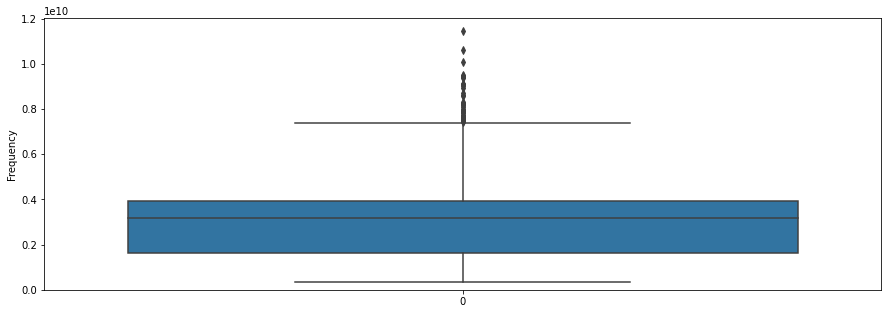

In [4]:
# OUTLIERS
df['Volume'].plot(kind='hist', bins=500,figsize=(15, 5))
plt.savefig("Outliers_Histogram.pdf")
sns.boxplot(data=df['Volume'])
plt.savefig("Outliers_Boxplot.pdf")
df = outliers(df,'Volume')

## TECHNICAL INDICATORS
* Importance of each technical indicator is ploted after training the model
* ML models can find some patterns between TA and trading volume, although it is very implausible
* Only the most important features are used
* Why? It would be hard to understand the behaviour of our model with so many features

In [5]:
df['VolumeDiff'] = df['Volume']-df['Volume'].shift(1)
df['Average'] = df.ta.midprice(length=1) #midprice
df['ATR'] = df.ta.atr(length=20)
df['RSI'] = df.ta.rsi(length=14)
df['MA40'] = df.ta.sma(length=40)
df['MA80'] = df.ta.sma(length=80)
df['MA140'] = df.ta.sma(length=140)
df["CCI"] = ta.cci(df.High, df.Low, df.Close, length=16)
df["AO"] = ta.ao(df.High, df.Low)
df["MOM"] = ta.mom(df.Close, length=16)
df["ATR"] = ta.atr(df.High, df.Low, df.Close, length=16)
df["BOP"] = ta.bop(df.Open, df.High, df.Low, df.Close, length=16)
df["RVI"] = ta.rvi(df.Close)
df["WPR"] = ta.willr(df.High, df.Low, df.Close, length=16)
df = pd.concat([df,ta.macd(df.Close, length = 16)],axis=1, join='inner')
df = pd.concat([df,ta.dm(df.High, df.Low, length=16)],axis=1, join='inner')
df = pd.concat([df,ta.stochrsi(df.Close, length=16)],axis=1, join='inner')
df = pd.concat([df,ta.stoch(df.High, df.Low, df.Close)],axis=1, join='inner')

## DATES
* There are no occuring patterns, therefore adding dates features should not be useful
* To prove the hypothesis we check it with the feature importance after training the model

In [6]:
def add_dates(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['Dayofweek'] = df.index.dayofweek
    df['Month'] = df.index.month
    df['Year'] = df.index.year
    df['Dayofmonth'] = df.index.day
    return df

In [7]:
df = add_dates(df)

## ADD LAGS
* Disclaimer: This is WIP
* No monthly/weekly/hourly occuring patterns as for exampel in power consumption
* What if there are some historically reocurring patterns?
    * What if the market behaves similarly as week/month/halfyear/year ago?
    * Well, then use unsupervised ML, not this :D
* No reason this should be helpful, since the ML models check for the reocurring patterns themselves
* Check the hypothesis in features importance, if these features are useful, come back and dive deep into it
* TODO: Investigate the reocurring patterns only with no other features (using unsupervised ML like DBSCAN?)

In [8]:
def add_lags(df):
    """
    Add historical data do dataframe df
    """
    df['Volume-Y/2'] = df['Volume'].shift(126) #252 trading days per year
    df['Volume-M'] = df['Volume'].shift(21)
    df['Volume-W'] = df['Volume'].shift(5)
    df['Volume-D'] = df['Volume'].shift(1)
    df['VolumeDiff-Y/2'] = df['VolumeDiff'].shift(126)
    df['VolumeDiff-M'] = df['VolumeDiff'].shift(21)
    df['VolumeDiff-W'] = df['VolumeDiff'].shift(5)
    df['VolumeDiff-D'] = df['VolumeDiff'].shift(1)
    return df

In [9]:
df = add_lags(df)

## TARGETS
   We are trying to predict three targets:
1) Target Volume: The trading volume for the next day, the one we want to predict
    * It will not be that easy :)
2) Target VolumeDiff: Difference between today volume and tomorrow
    * Why VolumeDiff? While predicting the volume, the ML will likely train to just predict the volume from previous day
3) TargetClass: 0 if volume in the next day decreases, 1 if increases
    * Why TargetClass? Predicting the exact volume difference still be too complex, what probability could be achieved if jsut predicting the rise or fall?

In [10]:
df['Target_Volume'] = df['Volume'].shift(-1)
df['Target_VolumeDiff'] = df['Volume'].shift(-1)-df['Volume']
df['Target_VolumeClass'] = [1 if df.Target_VolumeDiff[i]>0 else 0 for i in range(len(df))] #TODO: pridat komplexnejsi categorizaci

## DROP N/A VALUES
* Having N/A values in our dataset will make it harder to train the ML
* All N/A values are in the first half year of our training data (moving average and lags) and the very last day (missing target)
* Since we have 15 years of training data, missing half a year will probably not make such difference
* Another TODO: Does the model even with some N/A values in first half of the year predict better results?

In [11]:
# DROP THE NA VALUES
print(df.isna().sum())
df = df.dropna()
#df.reset_index(drop=True, inplace=True)
#df.reset_index('Date')
#print(*df.columns.tolist(), sep='\n')
#df.tail()

Open                     0
High                     0
Low                      0
Close                    0
Adj Close                0
Volume                   0
VolumeDiff               0
Average                  0
ATR                      3
RSI                      1
MA40                    26
MA80                    66
MA140                  126
CCI                      2
AO                      20
MOM                      3
BOP                      0
RVI                      0
WPR                      2
MACD_12_26_9            12
MACDh_12_26_9           20
MACDs_12_26_9           20
DMP_16                   3
DMN_16                   3
STOCHRSIk_16_14_3_3     18
STOCHRSId_16_14_3_3     20
STOCHk_14_3_3            2
STOCHd_14_3_3            4
Dayofweek                0
Month                    0
Year                     0
Dayofmonth               0
Volume-Y/2             126
Volume-M                21
Volume-W                 5
Volume-D                 1
VolumeDiff-Y/2         126
V

# DATA ANALYSIS
1) Occuring patterns: Are there any similarities in weekly/monthly/yearly basis?

## OCCURING PATTERNS?
* Check if there are some ireularities during days/weeks/months with higher trading volume
* No, there are not, throughout the weeks, months, years the volume is not showing any significant difference

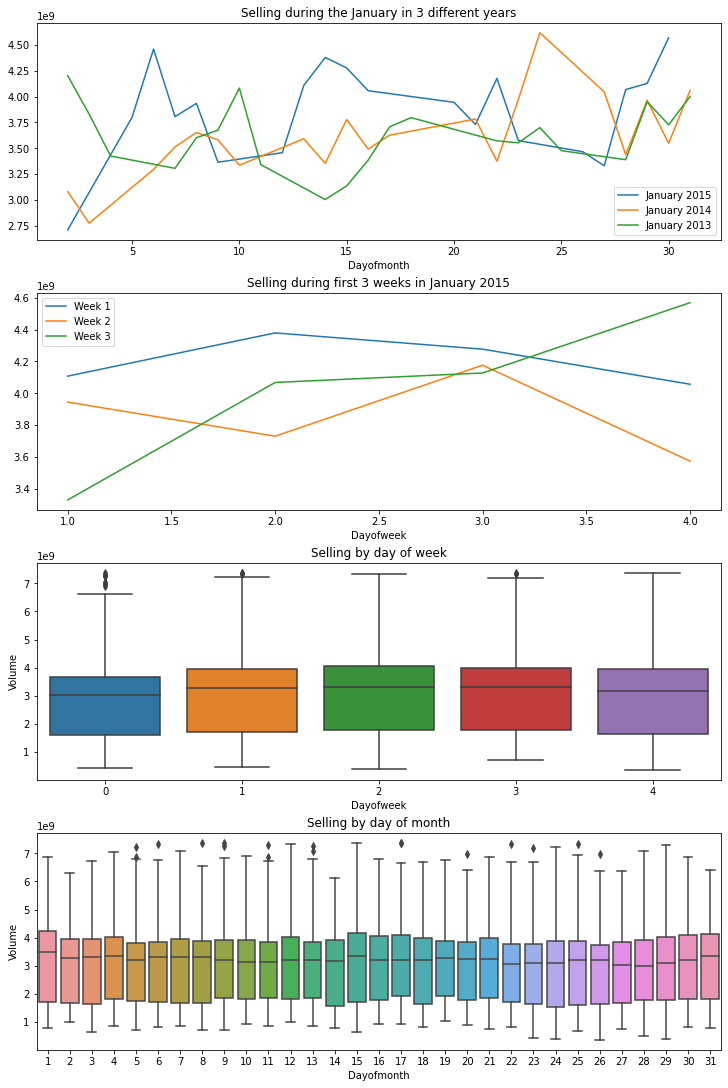

In [12]:
fig, axs = plt.subplots(4,1,figsize=(10, 15),constrained_layout = True)
df.loc[(df.index > '01-01-2015') & (df.index < '02-01-2015')].plot(ax=axs[0],x='Dayofmonth',y='Volume', label='January 2015')
df.loc[(df.index > '01-01-2014') & (df.index < '02-01-2014')].plot(ax=axs[0],x='Dayofmonth',y='Volume', label='January 2014')
df.loc[(df.index > '01-01-2013') & (df.index < '02-01-2013')].plot(ax=axs[0],x='Dayofmonth',y='Volume', label='January 2013')
axs[0].set_title('Selling during the January in 3 different years')

df.loc[(df.index > '01-12-2015') & (df.index < '01-19-2015')].plot(ax=axs[1],x='Dayofweek',y='Volume', label='Week 1')
df.loc[(df.index > '01-19-2015') & (df.index < '01-26-2015')].plot(ax=axs[1],x='Dayofweek',y='Volume', label='Week 2')
df.loc[(df.index > '01-26-2015') & (df.index < '02-02-2015')].plot(ax=axs[1],x='Dayofweek',y='Volume', label='Week 3')
axs[1].set_title('Selling during first 3 weeks in January 2015')

sns.boxplot(data=df, ax=axs[2],x='Dayofweek', y='Volume')
axs[2].set_title('Selling by day of week')

sns.boxplot(data=df, ax=axs[3],x='Dayofmonth', y='Volume')
axs[3].set_title('Selling by day of month')

plt.savefig('Occuring Patters.pdf')

## DISTRIBUTION
* Check if the data are evely distributed
* TODO: Standardization / Normalization if not

In [13]:
if FastRun is not True:
    cols = df.columns.tolist()
    fig, axs = plt.subplots(len(cols), 1,figsize=(15, len(cols)*3)) #TODO: zobrazit vsechno rozdeleni se spolecnou x osou, at zjistime, zda neco neni skew
    plt.suptitle('Distribution')
    for i in range(len(cols)):
        df[cols[i]].plot(kind='hist',ax=axs[i],title=cols[i])
    plt.savefig('Distribution.pdf')

## CORRELATION
* Correlation between all the features
* TODO: Investigate if the correlation is reasonable, if not, why?
* FastRun argument: Takes around 40s to generate, generate only if necessary

In [14]:
if FastRun is not True:
    plt.figure(figsize=(50, 50))
    plt.title('Correlation matrix of data')
    cor = df.corr()
    hm1 = sns.heatmap(cor, annot=True, cmap='YlGnBu')
    plt.savefig('Correlation.pdf')

## NORMALIZE
* Faster Convergence
* Correct axis ratio if we want for example compute distances between values
* FastRun argument: Takes around 40s to generate, generate only if necessary

In [15]:
if FastRun is not True:
    df_orig = df.copy()
    sc = MinMaxScaler()
    scaled = sc.fit_transform(df)
    df=pd.DataFrame(scaled,columns=df.columns,index=df.index)

## NORMALIZED DISTRIBUTION
* Check if the data are evenly distributed after normalization
* FastRun argument: Takes around 40s to generate, generate only if necessary

In [16]:
if FastRun is not True:
    cols = df.columns.tolist()
    fig, axs = plt.subplots(len(cols), 1,figsize=(15, len(cols)*3)) #TODO: zobrazit vsechno rozdeleni se spolecnou x osou, at zjistime, zda neco neni skew
    plt.suptitle('Normalised Distribution')
    for i in range(len(cols)):
        df[cols[i]].plot(kind='hist',ax=axs[i],title=cols[i])
    plt.savefig('Distribution Normalised.pdf')

# XGBOOST
* Kaggle competitions proved that this algprithm is very powerful
* Although my main focus is on transformers, XGBoost could give a great baseline
* Three different models are trained based on the target
    1) Next day volume
    2) Next day volume difference
    3) Next day volume class

In [34]:
# CHECK IF THE VALUES ARE REASONABLE
df.head()

,Open,High,Low,Close,Adj Close,Volume,VolumeDiff,Average,ATR,RSI,MA40,MA80,MA140,CCI,AO,MOM,BOP,RVI,WPR,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,DMP_16,DMN_16,STOCHRSIk_16_14_3_3,STOCHRSId_16_14_3_3,STOCHk_14_3_3,STOCHd_14_3_3,Dayofweek,Month,Year,Dayofmonth,Volume-Y/2,Volume-M,Volume-W,Volume-D,VolumeDiff-Y/2,VolumeDiff-M,VolumeDiff-W,VolumeDiff-D,Target_Volume,Target_VolumeDiff,Target_VolumeClass,prediction
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-07-21,1495.569946,1495.569946,1477.910034,1480.189941,1480.189941,968300000,-96300000.0,1486.739990,19.649192,51.839964,1463.355496,1454.986873,1438.314426,23.066220,24.521663,25.369995,-0.870899,54.037994,-44.902686,10.557491,0.116074,10.441416,4.449249,4.158791,41.335958,53.114461,60.606687,67.037290,4,7,2000,21,1.209800e+09,1.009600e+09,9.606000e+08,1.064600e+09,109100000.0,-21900000.0,-66200000.0,155200000.0,8.803000e+08,-88000000.0,0,NaN
2000-07-24,1480.189941,1485.880005,1463.800049,1464.290039,1464.290039,880300000,-88000000.0,1474.840027,19.801133,47.142581,1465.424747,1454.433998,1438.379212,-39.726409,17.118144,21.900024,-0.720106,46.880044,-67.459505,8.083198,-1.886575,9.969773,4.171138,4.780815,29.237241,40.938830,52.128401,59.917642,0,7,2000,24,1.115800e+09,1.022700e+09,9.060000e+08,9.683000e+08,-94000000.0,13100000.0,-54600000.0,-96300000.0,9.694000e+08,89100000.0,1,NaN
2000-07-25,1464.290039,1476.229980,1464.290039,1474.469971,1474.469971,969400000,89100000.0,1470.260010,19.309754,50.250806,1467.835995,1454.265872,1438.915283,-48.873201,10.774090,19.869995,0.852595,52.909972,-55.105501,6.864607,-2.484132,9.348739,3.910413,4.481981,15.732381,28.768527,42.982648,51.905912,1,7,2000,25,1.073700e+09,8.476000e+08,9.083000e+08,8.803000e+08,-42100000.0,-175100000.0,2300000.0,-88000000.0,1.235800e+09,266400000.0,1,NaN
2000-07-26,1474.469971,1474.469971,1452.420044,1452.420044,1452.420044,1235800000,266400000.0,1463.445007,19.481033,44.189423,1468.585248,1453.688873,1439.274641,-103.752837,5.949411,-17.119995,-1.000000,46.566125,-83.461929,4.072673,-4.220853,8.293526,3.665986,4.943780,6.307630,17.092418,25.565834,40.225628,2,7,2000,26,1.117300e+09,8.890000e+08,9.094000e+08,9.694000e+08,43600000.0,41400000.0,1100000.0,89100000.0,1.156400e+09,-79400000.0,0,NaN
2000-07-27,1452.420044,1464.910034,1445.329956,1449.619995,1449.619995,1156400000,-79400000.0,1455.119995,19.487224,43.472315,1469.310748,1452.984499,1439.604427,-135.162964,-1.092531,3.390015,-0.143005,40.150292,-87.062820,1.615483,-5.342435,6.957918,3.436840,5.077937,6.307630,9.449214,16.951238,28.499907,3,7,2000,27,1.129500e+09,1.042500e+09,1.064600e+09,1.235800e+09,12200000.0,153500000.0,155200000.0,266400000.0,9.800000e+08,-176400000.0,0,NaN


## MODEL 1 - VOLUME

### TRAIN/TEST SPLIT
* Make test and train split
* TODO: Try to experiment with train-valdiate-test, but k-fold cross validation is probably better

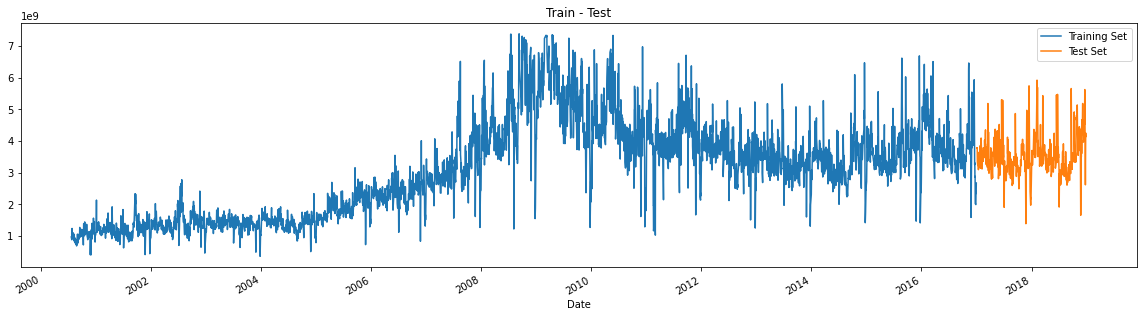

In [17]:
train = df.loc[df.index < '01-01-2017'].copy()
test = df.loc[df.index >= '01-01-2017'].copy()

fig, ax = plt.subplots(figsize=(20, 5))
train.plot(ax=ax, y='Volume',label='Training Set',title='Train - Test')
test.plot(ax=ax, y='Volume', label='Test Set')
plt.savefig("Train-Test Split.pdf")

### TRAINING
* Features: The attributes model is using as in input
* Target variables are the ones we predict
* Crucial to remove all Target values, as it already includes future data

In [83]:
print(df.columns.tolist())
FEATURES = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'VolumeDiff', 'Average', 'ATR', 'RSI', 'MA40', 'MA80', 'MA140', 'CCI', 'AO', 'MOM', 'BOP', 'RVI', 'WPR', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'DMP_16', 'DMN_16', 'STOCHRSIk_16_14_3_3', 'STOCHRSId_16_14_3_3', 'STOCHk_14_3_3', 'STOCHd_14_3_3', 'Dayofweek', 'Month', 'Year', 'Dayofmonth', 'Volume-Y/2', 'Volume-M', 'Volume-W', 'Volume-D', 'VolumeDiff-Y/2', 'VolumeDiff-M', 'VolumeDiff-W', 'VolumeDiff-D']
TARGET = 'Target_Volume'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=500,
                       objective='reg:linear',
                       max_depth=5,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'VolumeDiff', 'Average', 'ATR', 'RSI', 'MA40', 'MA80', 'MA140', 'CCI', 'AO', 'MOM', 'BOP', 'RVI', 'WPR', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'DMP_16', 'DMN_16', 'STOCHRSIk_16_14_3_3', 'STOCHRSId_16_14_3_3', 'STOCHk_14_3_3', 'STOCHd_14_3_3', 'Dayofweek', 'Month', 'Year', 'Dayofmonth', 'Volume-Y/2', 'Volume-M', 'Volume-W', 'Volume-D', 'VolumeDiff-Y/2', 'VolumeDiff-M', 'VolumeDiff-W', 'VolumeDiff-D', 'Target_Volume', 'Target_VolumeDiff', 'Target_VolumeClass', 'prediction_x', 'prediction_y', 'prediction', 'Prediction', 'Prediction_Volume']
[16:45:04] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:3321990407.03313	validation_1-rmse:3532839892.90830
[100]	validation_0-rmse:1298725325.51959	validation_1-rmse:1382642406.64396
[200]	v

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=500, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, objective='reg:linear', predictor='auto', ...)

### TESTING
* Using the trained model on test data
* Add column 'Prediction' to the dataset

In [77]:
test['Prediction_Volume'] = reg.predict(X_test)
df = df.merge(test[['Prediction_Volume']], how='left', left_index=True, right_index=True)

### FEATURE IMPORTANCE
* Year and Volume the most important
* Volume reasonable, since the model predicts same value as the day before
* TODO: Why year? It does not make any sense to me...

<AxesSubplot:title={'center':'Feature Importance'}>

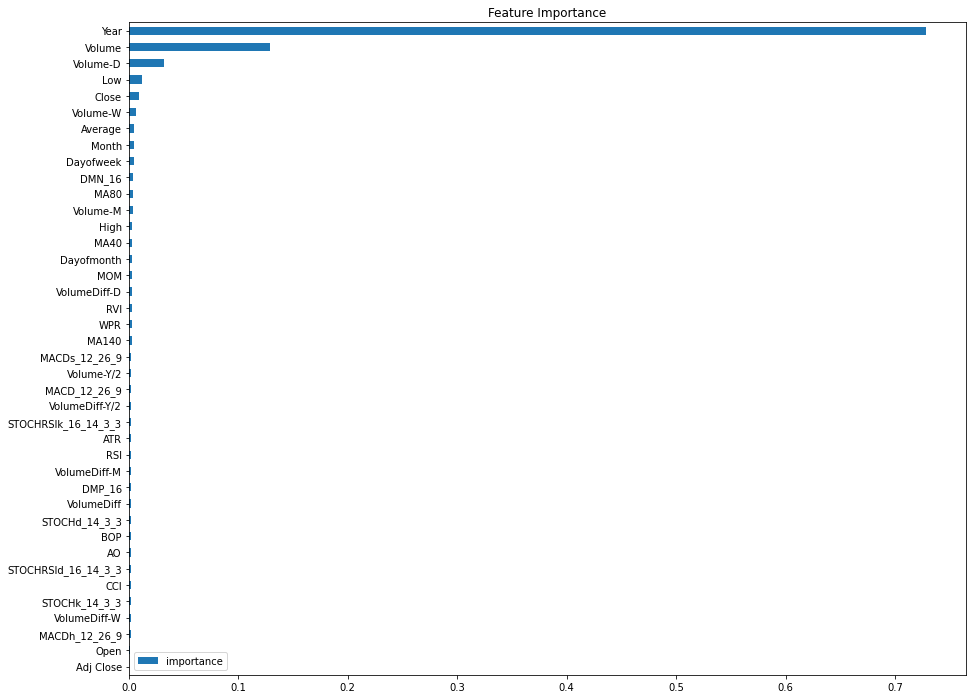

In [26]:
fi = pd.DataFrame(data=reg.feature_importances_,index=reg.feature_names_in_,columns=['importance'])
fi.sort_values('importance').plot(kind='barh', figsize=(15, 12),title='Feature Importance')
plt.savefig("XGB Volume Feature Importance.pdf")

### ANALYZE THE RESULTS
* It looks great on the yearly graph, hurraayy!
* When zoomed in, the model predicts the price from the previous day
* But it does not predict the previous price only, the RMSE score is better than baseline using the previous day values

date
2018-09-20    2.296135e+09
2017-12-14    2.263463e+09
2018-12-20    2.143451e+09
2018-06-21    2.081031e+09
2017-06-15    1.944485e+09
2018-11-21    1.872213e+09
2018-06-14    1.849437e+09
2017-06-22    1.837670e+09
2018-03-15    1.828674e+09
2017-03-16    1.689634e+09
Name: error, dtype: float64

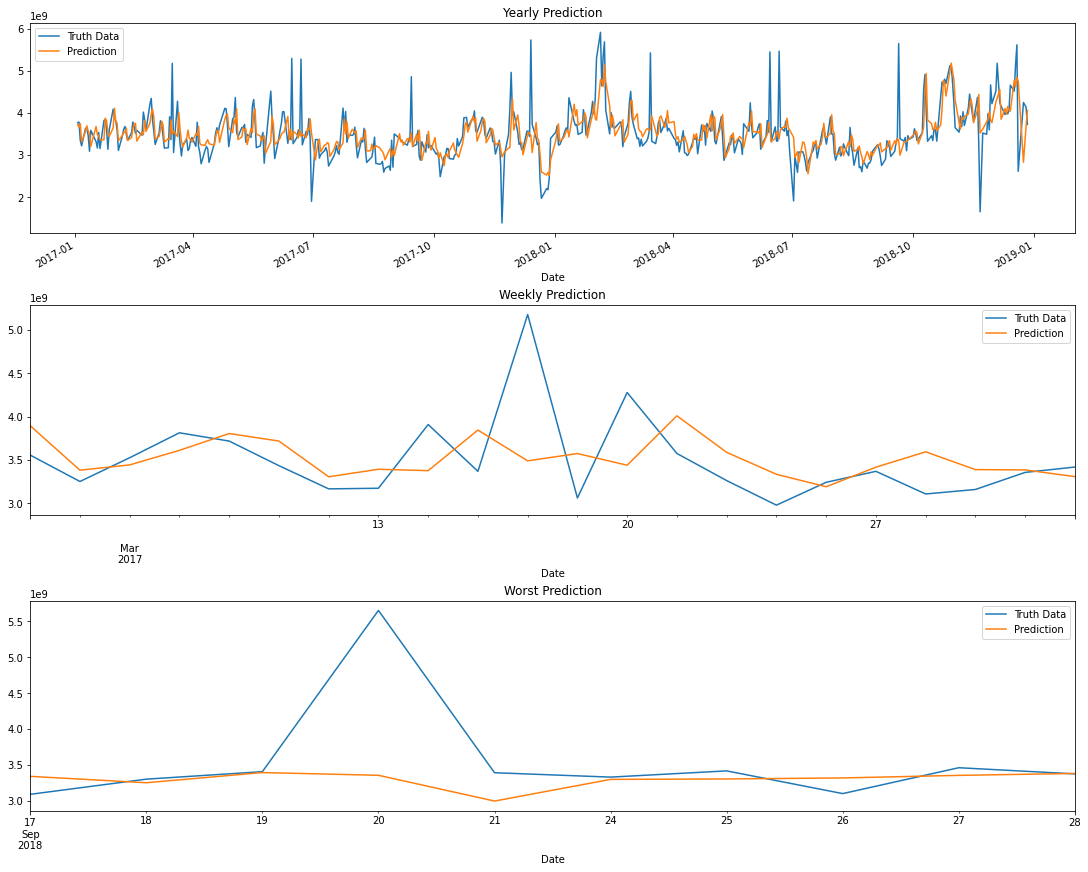

In [84]:
fig, axs = plt.subplots(3,1,figsize=(15, 12),constrained_layout = True)

df.loc[(df.index > '01-01-2017') & (df.index < '12-31-2018')].plot(ax=axs[0],y='Target_Volume',label='Truth Data')
df.loc[(df.index > '01-01-2017') & (df.index < '12-31-2018')].plot(ax=axs[0],y='Prediction_Volume',label='Prediction')
axs[0].set_title('Yearly Prediction')

df.loc[(df.index > '03-01-2017') & (df.index < '04-01-2017')].plot(ax=axs[1],y='Target_Volume',label='Truth Data')
df.loc[(df.index > '03-01-2017') & (df.index < '04-01-2017')].plot(ax=axs[1],y='Prediction_Volume',label ='Prediction')
axs[1].set_title('Weekly Prediction')

df.loc[(df.index > '09-15-2018') & (df.index < '09-30-2018')].plot(ax=axs[2],y='Target_Volume',label='Truth Data')
df.loc[(df.index > '09-15-2018') & (df.index < '09-30-2018')].plot(ax=axs[2],y='Prediction_Volume',label ='Prediction')
axs[2].set_title('Worst Prediction')

plt.savefig('XGB Predicted Volume.pdf')

In [85]:
# WORST PREDICTIONS
test['error'] = np.abs(test[TARGET] - test['Prediction_Volume'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2018-09-20    2.296135e+09
2017-12-14    2.263463e+09
2018-12-20    2.143451e+09
2018-06-21    2.081031e+09
2017-06-15    1.944485e+09
2018-11-21    1.872213e+09
2018-06-14    1.849437e+09
2017-06-22    1.837670e+09
2018-03-15    1.828674e+09
2017-03-16    1.689634e+09
Name: error, dtype: float64

## COMPARE THE RESULTS
* Crucial to compute the Predicted volume from difference
* Baseline model: Predicting previous day value

In [80]:
# MEAN SQUARED ERROR
score_baseline = np.sqrt(mean_squared_error(test['Volume'], test['Target_Volume']))
score_volume = np.sqrt(mean_squared_error(test['Volume'], test['Prediction_Volume']))
print(f'Baseline RMSE Score: {score_baseline:0.3f}')
print(f'Volume RMSE Score  : {score_volume:0.3f}')

# WORST AND BEST PREDICTED DATS

Baseline RMSE Score: 575655527.700
Volume RMSE Score  : 363605557.537


## MODEL 2 - Volume Diff

In [25]:
# DO NOT USE Open-High-Low-Close-Adj Close
# Why? We know the market! Which we do not in real life
FEATURES = ['ATR', 'RSI', 'MA40', 'MA80', 'MA160', 'CCI', 'AO', 'MOM', 'BOP', 'RVI', 'WPR', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'DMP_16', 'DMN_16', 'STOCHRSIk_16_14_3_3', 'STOCHRSId_16_14_3_3', 'STOCHk_14_3_3', 'STOCHd_14_3_3', 'Dayofweek', 'Month', 'Dayofmonth',  'Year_Ago', 'Half_Year_Ago', 'Month_Ago','TargetClass']
TARGET = 'Target'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=500,
                       objective='reg:linear',
                       max_depth=5,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

KeyError: "['MA160', 'Year_Ago', 'Half_Year_Ago', 'Month_Ago', 'TargetClass'] not in index"

### Feature Importance

In [ ]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', figsize=(15, 12),title='Feature Importance')

### Forecast on Test

In [ ]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['Volume']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
 

In [ ]:
ax = df.loc[(df.index > '01-01-2017') & (df.index < '12-31-2018')]['Volume'] \
    .plot(figsize=(15, 5), title='Predicted Volume')
df.loc[(df.index > '01-01-2017') & (df.index < '12-31-2018')]['prediction'] \
    .plot()
plt.legend(['Truth Data','Prediction'])
plt.savefig('Predicted Volume.pdf')

### Score (RMSE)

In [ ]:
score = np.sqrt(mean_squared_error(test['Volume'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.3f}')

### Calculate Error
- Look at the worst and best predicted days

In [ ]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

## K-FOLD CROSS VALDIATION
* Use the best model and run it using k-fold cross-validation
* TODO: Check which results are better

In [ ]:
print(df.isna().sum())
df.shape

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=10, test_size=183) #HALF OF THE YEAR
df = df.sort_index()

In [ ]:
fig, axs = plt.subplots(10, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['Volume'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['Volume'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
 

In [ ]:
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = add_dates(train)
    test = add_dates(test)

    FEATURES = ['Close', 'ATR', 'RSI', 'Dayofweek', 'Dayofmonth', 'Month']
    TARGET = 'Volume'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

In [ ]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

### Predicting the Future
- Retraining on all data
- To Predict the future we need an emtpy dataframe for future date ranges.
- Run those dates through our feature creation code + lag creation

In [ ]:
# Retrain on all data
df = add_dates(df)

FEATURES = ['Close', 'ATR', 'RSI', 'Dayofweek', 'Dayofmonth', 'Month']
TARGET = 'Volume'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

In [ ]:
df.index.max()

In [ ]:
# Create future dataframe
future = pd.date_range('2018-08-03','2019-08-01', freq='1d')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = add_dates(df_and_future)
df_and_future = add_lags(df_and_future)

In [ ]:
future_w_features = df_and_future.query('isFuture').copy()

### Predict the future

In [ ]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

In [ ]:
future_w_features['pred'].plot(figsize=(10, 5),
                               ms=1,
                               lw=1,
                               title='Future Predictions')
 

### Bonus: Saving Model For later

In [ ]:
# Save model
reg.save_model('model.json')

In [ ]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('model.json')
future_w_features['pred'] = reg_new.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(figsize=(10, 5),
                               ms=1, lw=1,
                               title='Future Predictions')

# PROPHET
- Prophet model expects the dataset to be named a specific way. We will rename our dataframe columns before feeding it into the model.
    - Datetime column named: `ds`
    - target : `y`

In [ ]:
# Format data for prophet model using ds and y
prophet_train = pjme_train.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'})

In [ ]:
%%time
model = Prophet()
model.fit(pjme_train_prophet)

In [ ]:
# Predict on test set with model
pjme_test_prophet = pjme_test.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'})

pjme_test_fcst = model.predict(pjme_test_prophet)

In [ ]:
pjme_test_fcst.head()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
 

In [ ]:
fig = model.plot_components(pjme_test_fcst)
 

## Compare Forecast to Actuals

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xbound(lower='01-01-2015',
              upper='02-01-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_ylim(0, 60000)
ax.set_title('First Week of January Forecast vs Actuals')
 

## Evaluate the model with Error Metrics

In [ ]:
np.sqrt(mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat']))

In [ ]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

In [ ]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

## Adding Holidays

Next we will see if adding holiday indicators will help the accuracy of the model. Prophet comes with a Holiday Effects parameter that can be provided to the model prior to training.

We will use the built in pandas USFederalHolidayCalendar to pull the list of holidays

In [ ]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()


holidays = cal.holidays(start=pjme.index.min(),
                        end=pjme.index.max(),
                        return_name=True)
holiday_df = pd.DataFrame(data=holidays,
                          columns=['holiday'])
holiday_df = holiday_df.reset_index().rename(columns={'index':'ds'})

In [ ]:
%%time
model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(pjme_train_prophet)

In [ ]:
# Predict on training set with model
pjme_test_fcst_with_hols = \
    model_with_holidays.predict(df=pjme_test_prophet)

In [ ]:
fig = model_with_holidays.plot_components(
    pjme_test_fcst_with_hols)
 

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst_with_hols, ax=ax)
ax.set_xbound(lower='07-01-2015',
              upper='07-07-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('July 4 Predictions vs Actual')

In [ ]:
np.sqrt(mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat']))

In [ ]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

In [ ]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

## Predict into the Future

We can use the built in `make_future_dataframe` method to build our future dataframe and make predictions.

In [ ]:
future = model.make_future_dataframe(periods=365*24, freq='h', include_history=False)
forecast = model_with_holidays.predict(future)

In [ ]:
forecast[['ds','yhat']].head()

# MIGHT DELETE LATER

## Model Building

#### Rozdělení na trénovací a testovací data

In [ ]:
x = data[['age', 'hypertension', 'heart_disease','bmi', 'gender_encoded', 'married_encoded','worktype_encoded','residence_encoded','smoker_encoded']]
y = data['stroke']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
sc = StandardScaler() # standardization of test and train set
x_train = sc.fit_transform(x_train)
x_test = sc.fit_transform(x_test)
print("Shape of x_train:{}".format(x_train.shape))
print("Shape of x_test:{}".format(x_test.shape))
print("Shape of y_train:{}".format(y_train.shape))
print("Shape of y_test:{}".format(y_test.shape))

#### Baseline
* the most basic algorithm, where we find whether is more probable to have or not have stroke in trainign dataset
* in the testing dataset, that everyone has or does not have a troke based on the first point
* useful to check whether other algorithms are working
* in this case the moct common scenario is NO STROKE

In [ ]:
# BASELINE
y_prediction = np.zeros(len(x_test), dtype=int)
accuracy = accuracy_score(y_test, y_prediction)

#### KNN
* implemented for 1-10 nearost neigbors
* runs the algorithm 9 times in total and use the k-negbors with the best result

In [ ]:
# KNN
best_accuracy = 0
best_k = 0
for k in range (1,10):
    model1 = KNeighborsClassifier(k).fit(x_train, y_train) # serach for k closest neigbors
    y_prediction1 = model1.predict(x_test)  # predict response
    accuracy1 = max(best_accuracy, accuracy_score(y_test, y_prediction1))
    if accuracy1 > best_accuracy: best_k = k
    best_accuracy = accuracy1

 #### DECISION TREE

In [ ]:
# DECISION TREE
decisiontree = DecisionTreeClassifier()  # Create models
model2 = decisiontree.fit(x_train, y_train)
y_prediction2 = model2.predict(x_test)  # predict response
accuracy2 = accuracy_score(y_test, y_prediction2)

#### SVM

In [ ]:
# SVM
svmmodel = svm.SVC(kernel='linear', probability=True)  # Linear Kernel
model3 = svmmodel.fit(x_train, y_train)
y_prediction3 = model3.predict(x_test)  # predict response
accuracy3 = accuracy_score(y_test, y_prediction3)

#### LOGISTIC REGRESSION

In [ ]:
# LOGISTIC REGRESSION
logisticregression = LogisticRegression()
model4 = logisticregression.fit(x_train, y_train)
y_prediction4 = model4.predict(x_test)  # predict response
accuracy4 = accuracy_score(y_test, y_prediction4)

## Results
* Baseline: dummiest, other algorithms should be able to be more accure
* KNN, Decision Tree, SVM, Logistic Regression

Decision trees are working the worst in this scenario, the rest is giving as the same results as baseline, which shows how hard the task is. As the majority of results are "no stroke", the algorithm learns on his own that it is the best to say that everything is not a stroke.

#### Predictions table

In [ ]:
report = pd.DataFrame()
report['Actual values'] = y_test
report['Predicted values KNN'] = y_prediction1
report['Predicted values Decision tree'] = y_prediction2
report['Predicted values SVM'] = y_prediction3
report['Predicted values Logistic Regression'] = y_prediction4
report.to_csv('predictions.csv') #save our predictions into csv file

#### Accuracies

In [ ]:
print("Baseline: ",accuracy)
print("KNN: ",accuracy1, "(for "+str(best_k)+" closest neigbors)")
print("Decision Trees: ", accuracy2)
print("SVM :", accuracy3)
print("Logistic Regression: ", accuracy4)

#### CONFUSION MATRIX

In [ ]:
ConfusionMatrix1 = confusion_matrix(y_test, y_prediction1)
ConfusionMatrix2 = confusion_matrix(y_test, y_prediction2)
ConfusionMatrix3 = confusion_matrix(y_test, y_prediction3)
ConfusionMatrix4 = confusion_matrix(y_test, y_prediction4)

# KNN
plt.subplots(2, 2, figsize=(10, 7))
plt.suptitle('Confusion Matrix')
plt.subplot(2, 2, 1)
ax = sns.heatmap(ConfusionMatrix1, annot=True, cmap="YlGnBu")
plt.title("KNN")
ax.set_ylabel('Actual values')

# DECISION TREE
plt.subplot(2, 2, 2)
ax = sns.heatmap(ConfusionMatrix2, annot=True, cmap="YlGnBu")
plt.title("Decision Tree")
ax.set_ylabel('Actual values')

# SVM
plt.subplot(2, 2, 3)
ax = sns.heatmap(ConfusionMatrix3, annot=True, cmap="YlGnBu")
plt.title("SVM")
ax.set_xlabel('Predicted values')
ax.set_ylabel('Actual values')

# LOGISTIC REGRESSION
plt.subplot(2, 2, 4)
ax = sns.heatmap(ConfusionMatrix4, annot=True, cmap="YlGnBu")
plt.title("Logistic Regression")
ax.set_xlabel('Predicted values')
ax.set_ylabel('Actual values')
plt.savefig('Confusion Matrix.pdf')

#### ROS CURVE

In [ ]:
    plt.subplots(2, 2, figsize=(10, 7))
    plt.suptitle('ROC Curve')
    plt.subplot(2, 2, 1)
    train_probs1 = model1.predict_proba(x_train)
    train_probs1 = train_probs1[:, 1]
    fpr1_train, tpr1_train, _ = roc_curve(y_train, train_probs1)  # pos_label=1
    test_probs1 = model1.predict_proba(x_test)
    test_probs1 = test_probs1[:, 1]
    fpr1_test, tpr1_test, _ = roc_curve(y_test, test_probs1)  # pos_label=1
    plt.plot(fpr1_train, tpr1_train, marker='.', label='train')
    plt.plot(fpr1_test, tpr1_test, marker='.', label='validation')
    plt.title('KNN')
    plt.ylabel('True Positive Rate')
    plt.legend()

    # ROC CURVE DECISION TREE
    plt.subplot(2, 2, 2)
    train_probs2 = model2.predict_proba(x_train)
    train_probs2 = train_probs2[:, 1]
    fpr2_train, tpr2_train, _ = roc_curve(y_train, train_probs2)  # pos_label=1
    test_probs2 = model2.predict_proba(x_test)
    test_probs2 = test_probs2[:, 1]
    fpr2_test, tpr2_test, _ = roc_curve(y_test, test_probs2)  # pos_label=1
    plt.plot(fpr2_train, tpr2_train, marker='.', label='train')
    plt.plot(fpr2_test, tpr2_test, marker='.', label='validation')
    plt.title('Decision Tree')
    plt.ylabel('True Positive Rate')
    plt.legend()

    # ROC CURVE MODEL SVM
    plt.subplot(2, 2, 3)
    train_probs3 = model3.predict_proba(x_train)
    train_probs3 = train_probs3[:, 1]
    fpr3_train, tpr3_train, _ = roc_curve(y_train, train_probs3)  # pos_label=1
    test_probs3 = model3.predict_proba(x_test)
    test_probs3 = test_probs3[:, 1]
    fpr3_test, tpr3_test, _ = roc_curve(y_test, test_probs3)  # pos_label=1
    plt.plot(fpr3_train, tpr3_train, marker='.', label='train')
    plt.plot(fpr3_test, tpr3_test, marker='.', label='validation')
    plt.title('SVM')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    # ROC CURVE LOGISTIC REGRESSION
    plt.subplot(2, 2, 4)
    train_probs4 = model4.predict_proba(x_train)
    train_probs4 = train_probs4[:, 1]
    fpr4_train, tpr4_train, _ = roc_curve(y_train, train_probs4)  # pos_label=1
    test_probs4 = model4.predict_proba(x_test)
    test_probs4 = test_probs4[:, 1]
    fpr4_test, tpr4_test, _ = roc_curve(y_test, test_probs4)  # pos_label=1
    plt.plot(fpr4_train, tpr4_train, marker='.', label='train')
    plt.plot(fpr4_test, tpr4_test, marker='.', label='validation')
    plt.title('Logistic Regression')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.savefig('ROC Curve.pdf')

### Predicting the Future
- Retraining on all data
- To Predict the future we need an emtpy dataframe for future date ranges.
- Run those dates through our feature creation code + lag creation

In [24]:
# TODO: Pokud nefunguje, vic info viz XBoost Part II
"""# Create future dataframe
future = pd.date_range('2017-01-01','2018-12-31', freq='1d')
future_df = pd.DataFrame(index=future,columns=df.columns)
future_df = add_dates(future_df)
future_df = add_lags(future_df)
#df_and_future = pd.concat([df, future_df])
#df_and_future = add_dates(df_and_future)
#df_and_future = add_lags(df_and_future)
#future_w_features = df_and_future.loc[df_and_future.index > '01-01-2017'].copy()
#future_w_features.head()
future_df['pred'] = reg.predict(future_df[FEATURES])
future_w_features['pred'].plot(figsize=(10, 5),
                               ms=1,
                               lw=1,
                               title='Future Predictions')
ax = df.loc[(df.index > '01-01-2017') & (df.index < '12-31-2018')]['Volume'].plot(figsize=(15, 5), title='Predicted Volume')
df.loc[(future_w_features.index > '01-01-2017') & (future_w_features.index < '12-31-2018')]['pred'].plot()
plt.legend(['Truth Data','Prediction'])
plt.savefig('Predicted Volume.pdf')
"""

"# Create future dataframe\nfuture = pd.date_range('2017-01-01','2018-12-31', freq='1d')\nfuture_df = pd.DataFrame(index=future,columns=df.columns)\nfuture_df = add_dates(future_df)\nfuture_df = add_lags(future_df)\n#df_and_future = pd.concat([df, future_df])\n#df_and_future = add_dates(df_and_future)\n#df_and_future = add_lags(df_and_future)\n#future_w_features = df_and_future.loc[df_and_future.index > '01-01-2017'].copy()\n#future_w_features.head()\nfuture_df['pred'] = reg.predict(future_df[FEATURES])\nfuture_w_features['pred'].plot(figsize=(10, 5),\n                               ms=1,\n                               lw=1,\n                               title='Future Predictions')\nax = df.loc[(df.index > '01-01-2017') & (df.index < '12-31-2018')]['Volume'].plot(figsize=(15, 5), title='Predicted Volume')\ndf.loc[(future_w_features.index > '01-01-2017') & (future_w_features.index < '12-31-2018')]['pred'].plot()\nplt.legend(['Truth Data','Prediction'])\nplt.savefig('Predicted Volume.